
# Tasca 7 : Transformació Registre Log amb Regular expressions

L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel i iniciar una resposta ràpida per mitigar els riscos.

## Nivell 1
L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han de normalitzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".

### Exercici 1
Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".



In [1]:
# Carga de librerias

# Data wrangling

import pandas as pd
import numpy as np

# Visualización de datos

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()

# Web scraping
from urllib.request import urlopen
import requests

from ip2geotools.databases.noncommercial import DbIpCity

from geolite2 import geolite2

# User agents parser
from ua_parser import user_agent_parser 

# Otros
import pickle
import re
import json


## Nivell 2
### Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.



## 1. Ingesta de datos.

Antes de empezar podemos leer en el siguiente [enlace] la estructura típica de un archivo de log.

Las piezas esperadas de información son:

[...]
- IP address of the client (remote host).
- The time that the server finished processing the request. The format is:

[day/month/year:hour:minute:second zone]
- The request line from the client is given in double quotes. 
- The status code that the server sends back to the client. 
- The size of the object returned to the client.
- The "Referer" (sic) HTTP request header. This gives the site that the client reports having been referred from. 
- The User-Agent HTTP request header. This is the identifying information that the client browser reports about itself.

[...]

[enlace]: http://httpd.apache.org/docs/1.3/logs.html


In [2]:
# Ingesta de datos.
logfile=pd.read_csv('Web_access_log-akumenius.txt',
                    sep='delimiter', 
                  #  nrows=100,
                    header=None,
                    engine='python',
                    )

He partido cada línea de mi archivo de manera con un delimitador _ "_ de manera que preveo que me quedarán 4 columnas con la soguiente información:

- 0. Dirección, IP y fecha.
- 1. Request: método, fuente, protocolo, status y tamaño.
- 2. Referer
- 3. User Agent

Espero que la información quede repartida en estas columnas, sin embargo puede ocurrir que existan algunos registros fuera de lo común o que se haya perdido alguna pieza de información, por eso vamos a revisar cada campo conforme extraigamos la información. 

In [3]:
# Cabecera
logfile.head(3)

,0
0,localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 ...
1,localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 ...
2,localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 ...


In [4]:
# Refistro num 181474
logfile.iloc[181474,:].values

array(['www.akumenius.com 220.181.108.96 - - [26/Feb/2014:23:44:31 +0100] "GET / HTTP/1.1" 200 25030 "-" "Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)" VLOG=-'],
      dtype=object)

In [5]:
# Información
logfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       261873 non-null  object
dtypes: object(1)
memory usage: 2.0+ MB


In [6]:
# Any missing values?
logfile.isna().any().sum()

0

In [7]:
# Duplicated rows
logfile[logfile.duplicated()].shape

(4563, 1)

No tenemos ninguna columna con valores nulos y hay 4.563 registros duplicados.

## 2. Extracción de variables.

### 2.1. DATE.

In [8]:
# Extracting DATE
log=logfile[0].str.extract(r'(?P<DATE>\d{2}/[A-Z][a-z]{2}/\d{4}[:\d\d]*\s.\d{4})',expand=True)

In [9]:
# Parsing to datetime
log.DATE=pd.to_datetime(log.DATE,format='%d/%b/%Y:%H:%M:%S %z',errors='ignore')

### 2.2. IP y WEB.

In [10]:
# Extraer dirección 
log['HOST']=logfile[0].str.extract(r'^(.*?\s)')
#logfile[0].str.split(' ',expand=True)[0]; #equivalente

In [11]:
# Extraer IP
log['IP']=logfile[0].str.extract(r'(\d+\.\d+\.\d+\.\d+)')

In [12]:
# Remote user
log['USER']=logfile[0].str.split(' ',expand=True)[3]

In [13]:
# Identidad
logfile[0].str.split(' ',expand=True)[2].unique()

array(['-'], dtype=object)

### 2.3. Variables derivadas de REQUEST.  

La información de request, referer y user agent está almacenada entre paréntesis. Voy a extraerla a un nuevo dataframe.

In [14]:
df=logfile[0].str.extractall(r'("[^"]*")')

In [15]:
df.head(5)

0
  match                                      
0 0                      "OPTIONS * HTTP/1.0"
  1                                       "-"
  2      "Apache (internal dummy connection)"
1 0                      "OPTIONS * HTTP/1.0"
  1                                       "-"

Se ha generado un multiindex con los matches de cada registro voy a reestructurar el dataframe para obtener los matches en columnas y los valores en registros.

In [16]:
df=df.unstack(level=1).stack(level=0)
df.head()

,match,0,1,2,3
0,0,"""OPTIONS * HTTP/1.0""","""-""","""Apache (internal dummy connection)""",NaN
1,0,"""OPTIONS * HTTP/1.0""","""-""","""Apache (internal dummy connection)""",NaN
2,0,"""OPTIONS * HTTP/1.0""","""-""","""Apache (internal dummy connection)""",NaN
3,0,"""OPTIONS * HTTP/1.0""","""-""","""Apache (internal dummy connection)""",NaN
4,0,"""OPTIONS * HTTP/1.0""","""-""","""Apache (internal dummy connection)""",NaN


Vemos que hay una columna más, probablemente debido a que en algún registro había algunas comillas en la descripción de la fuente.

In [17]:
df.isna().any()

match
0    False
1    False
2    False
3     True
dtype: bool

In [18]:
df[df[3].isna()==False]

,match,0,1,2,3
181473,0,"""GET /escapadas/escapada-especial-san-valentin-\""","""-en-playa-de-san-juan-hotel-castilla-alicante...","""-""","""Mozilla/5.0 (compatible; AhrefsBot/5.0; +http..."
236496,0,"""GET /escapadas/escapada-\""","""-observatorio-avifauna-hotel-pedro-i-de-arago...","""-""","""Mozilla/5.0 (compatible; AhrefsBot/5.0; +http..."


In [19]:
print(logfile.iloc[[181473],:][0].values)

['www.akumenius.com 5.10.83.41 - - [26/Feb/2014:23:44:22 +0100] "GET /escapadas/escapada-especial-san-valentin-\\"different\\"-en-playa-de-san-juan-hotel-castilla-alicante-80beffa7d651981e2b7abb7ad6a79508.html HTTP/1.1" 200 3100 "-" "Mozilla/5.0 (compatible; AhrefsBot/5.0; +http://ahrefs.com/robot/)" VLOG=-']


In [20]:
df=df.reset_index(level=1).drop(columns='level_1')

In [21]:
indices=df[df[3].isna()==False].index
indices

Int64Index([181473, 236496], dtype='int64')

In [22]:
df.loc[indices,0]=df.loc[indices,0]+df.loc[indices,1]
df.iloc[indices,:][0].values

array(['"GET /escapadas/escapada-especial-san-valentin-\\""-en-playa-de-san-juan-hotel-castilla-alicante-80beffa7d651981e2b7abb7ad6a79508.html HTTP/1.1"',
       '"GET /escapadas/escapada-\\""-observatorio-avifauna-hotel-pedro-i-de-aragon-e72dad4b21bdfb8f7285762400e8ba4b.html HTTP/1.1"'],
      dtype=object)

In [23]:
df.loc[indices,1]=df.loc[indices,2]
df.loc[indices,2]=df.loc[indices,3]
df.iloc[indices,:]

match,0,1,2,3
181473,"""GET /escapadas/escapada-especial-san-valentin...","""-""","""Mozilla/5.0 (compatible; AhrefsBot/5.0; +http...","""Mozilla/5.0 (compatible; AhrefsBot/5.0; +http..."
236496,"""GET /escapadas/escapada-\""""-observatorio-avif...","""-""","""Mozilla/5.0 (compatible; AhrefsBot/5.0; +http...","""Mozilla/5.0 (compatible; AhrefsBot/5.0; +http..."


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261873 entries, 0 to 261872
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       261873 non-null  object
 1   1       261873 non-null  object
 2   2       261873 non-null  object
 3   3       2 non-null       object
dtypes: object(4)
memory usage: 20.0+ MB


In [25]:
# Request Method
log['REQ_METHOD']=df[0].str.extract(r'([A-Z]+\s)')[0].str.strip()

In [26]:
log['REQ_METHOD'].unique()

array(['OPTIONS', 'GET', 'HEAD', 'POST', nan], dtype=object)

In [27]:
log['REQ_METHOD'].isna().sum()

42

Vemos que hay algunos registros sin request method, veamos que ocurre:

In [28]:
logfile[log['REQ_METHOD'].isna()][0].unique()

array(['localhost 220.181.108.108 - - [23/Feb/2014:14:14:41 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 69.61.47.114 - - [23/Feb/2014:16:42:58 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 220.181.108.79 - - [23/Feb/2014:19:21:43 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 188.87.251.64 - - [24/Feb/2014:08:48:59 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 180.76.5.214 - - [24/Feb/2014:10:23:25 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 62.175.136.122 - - [24/Feb/2014:13:08:00 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 62.175.136.122 - - [24/Feb/2014:13:08:01 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 62.175.136.122 - - [24/Feb/2014:13:08:02 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 87.111.221.104 - - [24/Feb/2014:13:28:49 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 87.111.221.104 - - [24/Feb/2014:13:30:51 +0100] "-" 408 - "-" "-" VLOG=-',
       'localhost 87.111.221.104 - - [24/Feb/2014:13:30:55 +0100] "-" 408 

No se genera un valor de **método** de request cuando hay:
- Error **408** que significa (_The client did not produce a request within the time that the server was prepared to wait. The client MAY repeat the request without modifications at any later time._ ) 
- O cuando hay una respuesta **\\x80w\\x01\\x03\\x01**, que tiene que ver con un error de autenticacion con el servidor.
Más adelante veremos como trato estos valores nulos en el campo METHOD.

In [29]:
# Request Source
log['REQ_SOURCE']=df[0].str.extract(r'([A-Z]+\s\S+\sH)')[0].str.split(' ',expand=True)[1]

In [30]:
log['REQ_SOURCE'].unique().shape

(66083,)

In [31]:
log['REQ_SOURCE'].isna().sum()

42

42 valores nulos que tienen correspondencia con los 42 registros que no generaron método de request.

In [32]:
# Protocolo
log['REQ_PROTOCOL']=df[0].str.extract(r'(HTTP/\d\.\d+)')

In [33]:
log['REQ_PROTOCOL'].unique() 

array(['HTTP/1.0', 'HTTP/1.1', nan], dtype=object)

In [34]:
log['REQ_SOURCE'].isna().sum()

42

Status y tamaño de archivo está en el archivo inicial y los extraeré desde allí. La manera más sencilla es dividiendo la cadena de caracteres con el comando split.

In [35]:
# Status
log['REQ_STATUS']=logfile[0].str.split('" ',expand=True)[1].str.split(' ',expand=True)[0]

In [36]:
log['REQ_STATUS'].unique() 

array(['200', '404', '304', '502', '301', '403', '408', '400', '206',
       '401', '302', '500'], dtype=object)

In [37]:
# Size
log['SIZE']=logfile[0].str.split('" ',expand=True)[1].str.split(' ',expand=True)[1]


In [38]:
log['SIZE'].unique().shape

(15548,)

In [39]:
# Any missing vale for size?
log['SIZE'].isna().any()

False

In [40]:
# Not numeric values for SIZE
log.shape[0]-log['SIZE'].str.isnumeric().sum()

42335

In [41]:
# Diferent values for no numeric in SIZE
log[log['SIZE'].str.isnumeric()==False]['SIZE'].unique()

array(['-'], dtype=object)

En la variable tamaño tenemos un grupo de valores '-' que representan cero bites.

### 2.4. REFERER y AGENT-USER

In [42]:
# Referer
log['REFERER']=df[1].str.slice(1,-1)

In [43]:
log['REFERER'].unique().shape

(2507,)

In [44]:
# Agent-User
log['USER-AGENT']=df[2].str.slice(1,-1)

In [45]:
# Número de UA diferentes
log['USER-AGENT'].unique().shape

(735,)

In [46]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype                               
---  ------        --------------   -----                               
 0   DATE          261873 non-null  datetime64[ns, pytz.FixedOffset(60)]
 1   HOST          261873 non-null  object                              
 2   IP            261873 non-null  object                              
 3   USER          261873 non-null  object                              
 4   REQ_METHOD    261831 non-null  object                              
 5   REQ_SOURCE    261831 non-null  object                              
 6   REQ_PROTOCOL  261831 non-null  object                              
 7   REQ_STATUS    261873 non-null  object                              
 8   SIZE          261873 non-null  object                              
 9   REFERER       261873 non-null  object                              
 10  USER-AGE

In [47]:
# Elimino archivos que no necesito
del df

### 2.5.1. Asignando valores Nan.

Hemos visto que hay 42 registros que no han generado un request apropiado, así que vamos a asignarle un valor adecuado para que dejen de contar como nulos.

In [48]:
log[log['REQ_METHOD'].isna()]

,DATE,HOST,IP,USER,REQ_METHOD,REQ_SOURCE,REQ_PROTOCOL,REQ_STATUS,SIZE,REFERER,USER-AGENT
17928,2014-02-23 14:14:41+01:00,localhost,220.181.108.108,-,NaN,NaN,NaN,408,-,-,-
24211,2014-02-23 16:42:58+01:00,localhost,69.61.47.114,-,NaN,NaN,NaN,408,-,-,-
29514,2014-02-23 19:21:43+01:00,localhost,220.181.108.79,-,NaN,NaN,NaN,408,-,-,-
49414,2014-02-24 08:48:59+01:00,localhost,188.87.251.64,-,NaN,NaN,NaN,408,-,-,-
52518,2014-02-24 10:23:25+01:00,localhost,180.76.5.214,-,NaN,NaN,NaN,408,-,-,-
64244,2014-02-24 13:08:00+01:00,localhost,62.175.136.122,-,NaN,NaN,NaN,408,-,-,-
64249,2014-02-24 13:08:01+01:00,localhost,62.175.136.122,-,NaN,NaN,NaN,408,-,-,-
64251,2014-02-24 13:08:02+01:00,localhost,62.175.136.122,-,NaN,NaN,NaN,408,-,-,-
66209,2014-02-24 13:28:49+01:00,localhost,87.111.221.104,-,NaN,NaN,NaN,408,-,-,-
66370,2014-02-24 13:30:51+01:00,localhost,87.111.221.104,-,NaN,NaN,NaN,408,-,-,-


Hay dos causas para estos Nan, los errores 408 y los 400 y tienen que tratarse de forma diferente.

Para los errores 408 (Time out) dejaremos todos los valores en 'Unknown' i '-'.

Para los errores 400 (bad request) asignaremos \x80w\x01\x03\x01 al REQ_METHOD y '-' al resto.

In [49]:
log.loc[(log['REQ_METHOD'].isna())&(log['REQ_STATUS']=='400'),'REQ_METHOD']='\\x80w\\x01\\x03\\x01'

In [50]:
log.loc[(log['REQ_METHOD'].isna())&(log['REQ_STATUS']=='408'),'REQ_METHOD']='-'

In [51]:
log[log['REQ_PROTOCOL'].isna()]

,DATE,HOST,IP,USER,REQ_METHOD,REQ_SOURCE,REQ_PROTOCOL,REQ_STATUS,SIZE,REFERER,USER-AGENT
17928,2014-02-23 14:14:41+01:00,localhost,220.181.108.108,-,-,NaN,NaN,408,-,-,-
24211,2014-02-23 16:42:58+01:00,localhost,69.61.47.114,-,-,NaN,NaN,408,-,-,-
29514,2014-02-23 19:21:43+01:00,localhost,220.181.108.79,-,-,NaN,NaN,408,-,-,-
49414,2014-02-24 08:48:59+01:00,localhost,188.87.251.64,-,-,NaN,NaN,408,-,-,-
52518,2014-02-24 10:23:25+01:00,localhost,180.76.5.214,-,-,NaN,NaN,408,-,-,-
64244,2014-02-24 13:08:00+01:00,localhost,62.175.136.122,-,-,NaN,NaN,408,-,-,-
64249,2014-02-24 13:08:01+01:00,localhost,62.175.136.122,-,-,NaN,NaN,408,-,-,-
64251,2014-02-24 13:08:02+01:00,localhost,62.175.136.122,-,-,NaN,NaN,408,-,-,-
66209,2014-02-24 13:28:49+01:00,localhost,87.111.221.104,-,-,NaN,NaN,408,-,-,-
66370,2014-02-24 13:30:51+01:00,localhost,87.111.221.104,-,-,NaN,NaN,408,-,-,-


In [52]:
log.loc[log['REQ_PROTOCOL'].isna(),['REQ_SOURCE','REQ_PROTOCOL']]='-'

In [53]:
# Any Nan
log.isna().any()

DATE            False
HOST            False
IP              False
USER            False
REQ_METHOD      False
REQ_SOURCE      False
REQ_PROTOCOL    False
REQ_STATUS      False
SIZE            False
REFERER         False
USER-AGENT      False
dtype: bool

Hemos visto que en la columna SIZE había valores nulos con formato '-', como quiero convertir esta columna a tipo numérico vamos a sustituir este valor por 0.

In [54]:
# Imputo a 0 Nan de SIZE
log.loc[log['SIZE']=='-','SIZE']=0

In [55]:
# SIZE a NUMERICO
log['SIZE']=log['SIZE'].astype('int')

In [56]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype                               
---  ------        --------------   -----                               
 0   DATE          261873 non-null  datetime64[ns, pytz.FixedOffset(60)]
 1   HOST          261873 non-null  object                              
 2   IP            261873 non-null  object                              
 3   USER          261873 non-null  object                              
 4   REQ_METHOD    261873 non-null  object                              
 5   REQ_SOURCE    261873 non-null  object                              
 6   REQ_PROTOCOL  261873 non-null  object                              
 7   REQ_STATUS    261873 non-null  object                              
 8   SIZE          261873 non-null  int32                               
 9   REFERER       261873 non-null  object                              
 10  USER-AGE

In [57]:
log=log.sort_values(by='DATE')

## 3. Nuevas variables.

### 3.1. Variables derivadas de la fecha.

Voy a crear tres variables derivadas de la fecha, dia de la semana y hora del día

In [58]:
log['DATE'].min(),log['DATE'].max()

(Timestamp('2014-02-23 03:10:31+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2014-03-02 03:10:18+0100', tz='pytz.FixedOffset(60)'))

Parece que tenemos los registros de una semana.

In [59]:
log['DAYoWEEK']=log['DATE'].dt.dayofweek

In [60]:
log['Hour']=log['DATE'].dt.hour

### Exercici 3
Geolocalitza les IP's. Aqui tens una pagina de interes :IP2Locattion: https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/



### 3.2. Variables derivadas de IP. Geolocalización.

Voy a obtener primero un array con las direciones con el método unique. Este array será el que usemos para extraer la información. 

In [61]:
log['IP'].unique().shape

(2921,)

Han accedido a nuestra web 2921 IPs diferentes.Voy a intentar geolocalizarlas y añadir la información de país, ciudad y región.

In [62]:
# Extraigo listado de direcciones IP
IPS=log['IP'].unique()

In [63]:
# Array a dataframe
IPS=pd.DataFrame(IPS)

#### 3.2.1. Freegeoip.

Escribo una función utilizando la librería urllib2 y posteriormente utilizo apply para aplicar la función a cada fila del dataframe de IPs.

In [64]:
# Defino una función que obtenga los datos de geolocalización de las IPs
def ipInfo(addr=""):
    if addr == "":
        url = "https://freegeoip.app/json/"
    else:
        url = "https://freegeoip.app/json/" + addr 

    response = urlopen(url)
    data = json.load(response)
    return data

In [65]:
# Scrapping 
#CITY=IPS[0].apply(lambda x: ipInfo(x))

In [66]:
#CITY # archivo con datos de ubicación de IPs

In [67]:
# File to pickle (guardo el archivo en formato binario)
#with open('geoloc.pickle','wb') as archivo:
#        pickle.dump(CITY,archivo)

In [68]:
#import requests
#def geolocaliza(IP):
#    archivo=requests.get('http://www.geoplugin.net/json.gp?ip='+var)
#    return json.loads(archivo.content)

In [69]:
#geoplugin_dic=IPS[0].apply(lambda x: geolocaliza(x))

In [70]:
# Load geolocalization data
IPSs=pd.read_pickle('geoloc.pickle')

In [71]:
diccionario=IPSs.to_dict()
len(diccionario)

2921

In [72]:
IPSs=pd.DataFrame.from_dict(diccionario,orient='index')
IPSs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ip            2921 non-null   object 
 1   country_code  2921 non-null   object 
 2   country_name  2921 non-null   object 
 3   region_code   2921 non-null   object 
 4   region_name   2921 non-null   object 
 5   city          2921 non-null   object 
 6   zip_code      2921 non-null   object 
 7   time_zone     2921 non-null   object 
 8   latitude      2921 non-null   float64
 9   longitude     2921 non-null   float64
 10  metro_code    2921 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 273.8+ KB


In [73]:
IPSs.loc[IPSs['country_name']=='','country_name']='Unknown'
IPSs.loc[IPSs['city']=='','city']='Unknown'
IPSs.loc[IPSs['region_name']=='','region_name']='Unknown'

In [74]:
# Missed data
IPSs[IPSs['country_name']=='Unknown'].shape[0],IPSs[IPSs['city']=='Unknown'].shape[0],IPSs[IPSs['region_name']=='Unknown'].shape[0]

(14, 1090, 902)

#### 3.2.2. Ip2geotools.

En este caso voy a probar con la base de datos DbIpCity de Ip2geotools.

In [75]:
# Función para obtener datos IPs
def localiza(ip):
    try:
        resp = DbIpCity.get(ip, api_key='free')
        return (ip,resp.country,resp.city)
    except:
        return (ip,np.nan,np.nan)

In [76]:
#nuevas_ips=IPS[0].apply(lambda x:localiza(x))

In [77]:
#Obtengo datos IPs
#nuevas_ips=pd.DataFrame.from_records(nuevas_ips,columns=['IP','country','city'])

In [78]:
# File to pickle (guardo el archivo en formato binario)
#with open('DbIpCity_Ip2geotools.pickle','wb') as archivo:
#        pickle.dump(nuevas_ips,archivo)

In [79]:
nuevas_ips=pd.read_pickle('DbIpCity_Ip2geotools.pickle')

In [80]:
#nuevas_ips

In [81]:
nuevas_ips.isna().sum(axis=0)

IP            0
country    1914
city       1914
dtype: int64

#### 3.2.3. Geolite2.

En este caso voy a probar con la API de Geolite.

In [82]:
# Función para obtener datos IPs
def geolite_2(ip):
    try:
        x=geolite2.reader().get(ip)
        tupla=(ip,
               x['country']['names']['es'],
               x['city']['names']['es'],
               x['subdivisions'][0]['names']['es'])
        geolite2.close()
        return tupla
    except:
        return (ip,np.nan,np.nan,np.nan)


In [83]:
#IPS_geolite=IPS[0].apply(lambda x:geolite_2(x))

In [84]:
#Obtengo datos IPs
#IPS_geolite=pd.DataFrame.from_records(IPS_geolite,columns=['IP','country','city','region'])

In [85]:
# File to pickle (guardo el archivo en formato binario)
#with open('geolite2.pickle','wb') as archivo:
#        pickle.dump(IPS_geolite,archivo)

In [86]:
IPS_geolite=pd.read_pickle('geolite2.pickle')

In [87]:
IPS_geolite.isna().sum(axis=0)

IP            0
country    1477
city       1477
region     1477
dtype: int64

In [88]:
geolite_2('80.28.221.123')

('80.28.221.123', 'España', 'Torrejón de Ardoz', 'Madrid')

In [89]:
IPS_geolite

,IP,country,city,region
0,127.0.0.1,NaN,NaN,NaN
1,66.249.76.216,NaN,NaN,NaN
2,5.255.253.53,NaN,NaN,NaN
3,157.55.35.112,Estados Unidos,Redmond,Washington
4,193.111.141.116,Alemania,Düsseldorf,Renania del Norte-Westfalia
...,...,...,...,...
2916,46.222.83.180,NaN,NaN,NaN
2917,79.155.78.117,España,Madrid,Madrid
2918,217.174.248.179,Reino Unido,Gloucester,Inglaterra
2919,188.135.173.80,NaN,NaN,NaN


#### 3.2.4. Trasladando los datos al archivo log.

Parece que freegeoip es la página que más resultados nos ha dado, así que trabajaré con este archivo.

Ahora solo quedaría hacer un merge de la tabla log con los datos de IPSs para obtener ciudad y pais.

In [90]:
log=log.merge(IPS_geolite[['IP','city','country','region']],
         how='left',
         left_on='IP',
         right_on='IP')#.drop(columns='IP')

### 3.3. Extrayendo información de la variable user agent.

El campo user agent nos puede proporcionar mucha información sobre quien está accediendo a nuestro sitio. Para extraerla voy a utilizar una librería específica **ua-parser**. Para un primer análisis voy a extraer la información del sistema operativo y del dispositivo.

In [91]:
# Información sobre sistema operativo
log['OS_info']=log['USER-AGENT'].apply(lambda x:user_agent_parser.ParseOS(x)['family'])

In [92]:
# Información sobre DISPOSITIVO
log['DEVICE_info']=log['USER-AGENT'].apply(lambda x:user_agent_parser.ParseDevice(x)['family'])

In [93]:
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261873 entries, 0 to 261872
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype                               
---  ------        --------------   -----                               
 0   DATE          261873 non-null  datetime64[ns, pytz.FixedOffset(60)]
 1   HOST          261873 non-null  object                              
 2   IP            261873 non-null  object                              
 3   USER          261873 non-null  object                              
 4   REQ_METHOD    261873 non-null  object                              
 5   REQ_SOURCE    261873 non-null  object                              
 6   REQ_PROTOCOL  261873 non-null  object                              
 7   REQ_STATUS    261873 non-null  object                              
 8   SIZE          261873 non-null  int32                               
 9   REFERER       261873 non-null  object                              
 10  USER-AGE

In [94]:
# 
#log.loc[log['country_name']=='','country_name']='Unknown'
#log.loc[log['city']=='','city']='Unknown'

In [95]:
#log.columns.to_list()

In [96]:
campos=['DATE','DAYoWEEK', 'Hour','USER', 'HOST', 'IP', 'REQ_METHOD', 'REQ_SOURCE', 'REQ_PROTOCOL',
 'REQ_STATUS', 'SIZE', 'REFERER', 'USER-AGENT','city','region','country','OS_info','DEVICE_info']

In [97]:
log=log.reindex(columns=campos)

### 3.4. Generando un archivo csv. 

In [98]:
#log.to_csv('log_clean.csv',index=False)

In [99]:
log.to_csv('log_clean_geolite.csv',index=False)

## Nivell 3
### Exercici 4
Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.



## 4. Análisis explaratorio.

Para el análisis exploratorio de datos voy a trabajar con una copia del dataframe original. 

In [2]:
#Dateframe para el análisis
df=pd.read_csv('log_clean_geolite.csv') #geolite2
#df=pd.read_csv('log_clean.csv')  #freegeoapp
#df=log.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DATE          261873 non-null  object
 1   DAYoWEEK      261873 non-null  int64 
 2   Hour          261873 non-null  int64 
 3   USER          261873 non-null  object
 4   HOST          261873 non-null  object
 5   IP            261873 non-null  object
 6   REQ_METHOD    261873 non-null  object
 7   REQ_SOURCE    261873 non-null  object
 8   REQ_PROTOCOL  261873 non-null  object
 9   REQ_STATUS    261873 non-null  int64 
 10  SIZE          261873 non-null  int64 
 11  REFERER       261873 non-null  object
 12  USER-AGENT    261873 non-null  object
 13  city          142337 non-null  object
 14  region        142337 non-null  object
 15  country       142337 non-null  object
 16  OS_info       261873 non-null  object
 17  DEVICE_info   261873 non-null  object
dtypes: int64(4), object(14)


In [4]:
df.loc[df['country'].isna(),'country']='Unknown'
df.loc[df['city'].isna(),'city']='Unknown'
df.loc[df['region'].isna(),'region']='Unknown'

### 4.1. Comportamiento del tráfico de mi web en el tiempo.

Para analizar la evolución del tráfico en el tiempo creo la variable día extrayendo la fecha de la variable DATE y me quedo con las variables relativa a la HORA y el DÍA DE LA SEMANA.

In [5]:
#df['TIME']=log.DATE.dt.time

In [6]:
df.DATE.min(),df.DATE.max()

('2014-02-23 03:10:31+01:00', '2014-03-02 03:10:18+01:00')

In [7]:
df.DATE=pd.to_datetime(df.DATE,format='%Y-%m-%d %H:%M:%S%z')

In [8]:
df['DIA']=df.DATE.dt.strftime('%b/%d/%Y')
df.DAYoWEEK=df.DATE.dt.day_name()
df.drop(columns='DATE',inplace=True);

In [9]:
df.DIA.min(),df.DIA.max()

('Feb/23/2014', 'Mar/02/2014')

In [10]:
df.DAYoWEEK.head(1),df.DAYoWEEK.tail(1)

(0    Sunday
 Name: DAYoWEEK, dtype: object,
 261872    Sunday
 Name: DAYoWEEK, dtype: object)

In [11]:
df.groupby(['DIA','DAYoWEEK'])[['IP']].count()

,,IP
DIA,DAYoWEEK,
Feb/23/2014,Sunday,40536
Feb/24/2014,Monday,48850
Feb/25/2014,Tuesday,55798
Feb/26/2014,Wednesday,36473
Feb/27/2014,Thursday,41513
Feb/28/2014,Friday,19570
Mar/01/2014,Saturday,17749
Mar/02/2014,Sunday,1384


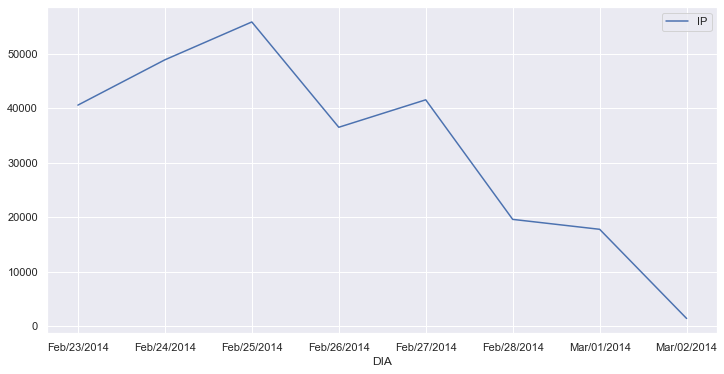

In [12]:
# Evolución visitas diarias
df.groupby(['DIA'])[['IP']].count().plot(figsize=(12,6));

Tenemos un registro de navegación entre los días 23 de febrero y 2 de marzo, que va de domingo a domingo, en esta tabla el primer y último día no son completos. 

De domingo a jueves el tráfico está entre las 36k y las 55k visitas, mientras que viernes y sábado cae a la mitad. Probablemente se deba a que la mayoría de las reservas se hacen de domingo a jueves y los usuarios viajan en fin de semana.

Veamos ahora cuales son las horas con más tráfico.

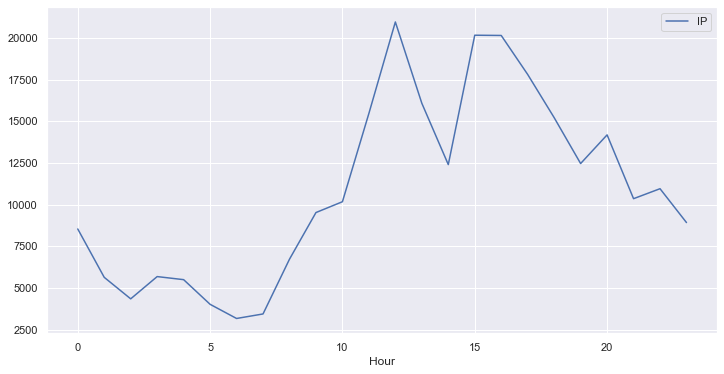

In [111]:
# Visitas totales por franja horaria
df.groupby(['Hour'])[['IP']].count().plot(figsize=(12,6));

Entre las 10 y las 20 hay más de 10k visitas a la hora, llegando a más de 20k entre las 12 y las 17.

Todo este tráfico no corresponde únicamente a usuarios humanos, si no que también hay bots que recorren la web automáticamente. Vamos a filtrar este tipo de tráfico para quedarnos con el tráfico humano. 

In [13]:
#Variable tipo de tráfico
df['Traffic']='Human'
df.loc[df.DEVICE_info=='Spider','Traffic']='Bot'

In [14]:
#Trafico usuarios humanos
realtrafic=df[df.DEVICE_info!='Spider']

In [15]:
#Trafico bots
bottrafic=df[df.DEVICE_info=='Spider']

In [115]:
#df.groupby(['DIA','REQ_METHOD'])[['IP']].count()

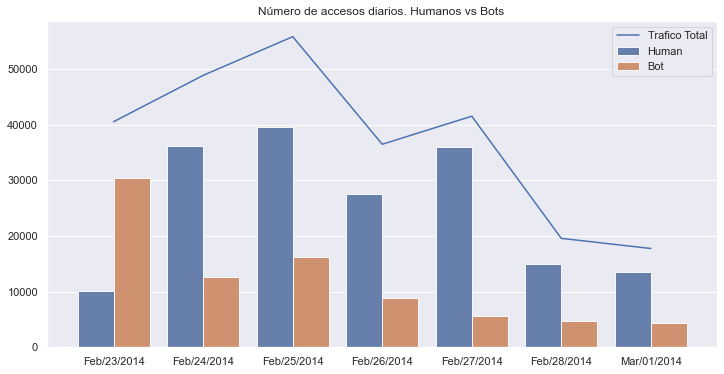

In [17]:

# Trafico semanal

# 1. Preparo datos

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot
trafico=sns.countplot(data=df.query('DIA!="Mar/02/2014"'),
                        x='DIA',
                        hue='Traffic',
                        alpha=0.9,
                        ax=ax)

sns.lineplot(data=df.query('DIA!="Mar/02/2014"').groupby(['DIA'])[['IP']].count(),
             x='DIA',
             y='IP',
             ax=ax,
             legend='full',
             label='Trafico Total')


# 4. Configuracion de imagen y anotaciones 
trafico.set(title='Número de accesos diarios. Humanos vs Bots ',
          ylabel=None,
          xlabel=None);



Ahora podemos observar que la mayoría de las visitas del domingo corresponden a bots que están recorriendo nuestra web.  

Además vemos que el tráfico en nuestra página alcanza un máximo lunes y martes, tal vez debido a que los usuarios planean su escapada para el fin de semana y luego se observa una tendencia descendente hasta el fin de semana donde se alcanza un mínimo de visitas el sábado y domingo, aunque el jueves se observa un número de visitas que rompe la tendencia descendente.

In [117]:
#bottrafic.groupby(['Hour'])[['IP']].count().plot(figsize=(12,6));

In [118]:
#realtrafic.groupby(['Hour'])[['IP']].count().plot(figsize=(12,6));

A continuación quiero analizar los Megabytes de tráfico que hubo en nuestra página.

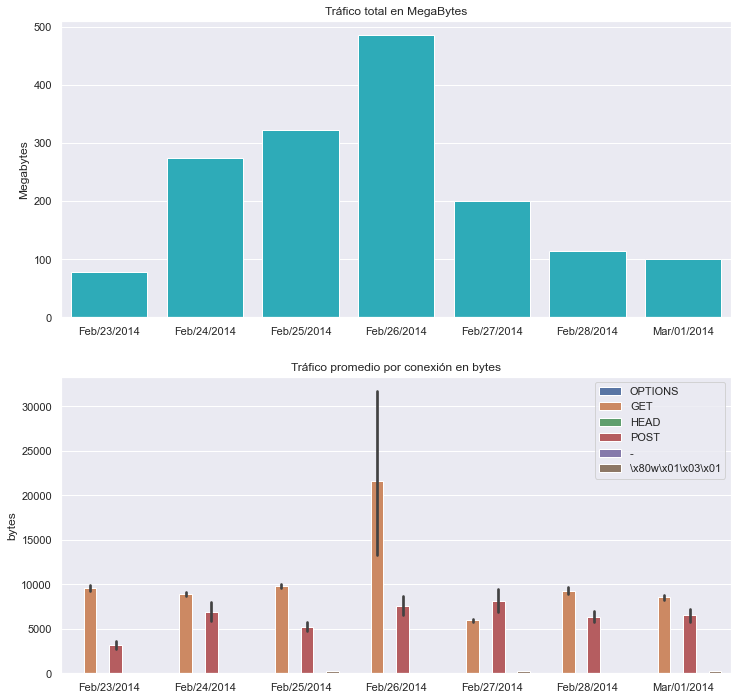

In [119]:
# Histograma de número de visitas por dia
# 1. Preparo datos
Megas=lambda x: np.sum(x)/(1024**2)

# 2. Creo fig y axes.
fig,(ax1,ax2)=plt.subplots(figsize=(12, 12),ncols=1,nrows=2)

# 3. Creo Plot
trafico=sns.barplot(data=realtrafic.query('DIA!="Mar/02/2014"'),
                    estimator=Megas,
                    ci=None,
                    x='DIA',
                    y='SIZE',
                    color='tab:cyan',
                    ax=ax1)

trafico_promedio=sns.barplot(data=realtrafic.query('DIA!="Mar/02/2014"'),
                  #  ci='sd',
                    x='DIA',
                    y='SIZE',
                    hue='REQ_METHOD',
                    ax=ax2)



# 4. Configuracion de imagen y anotaciones 
trafico.set(title='Tráfico total en MegaBytes',
          ylabel='Megabytes',
          xlabel=None);

trafico_promedio.set(title='Tráfico promedio por conexión en bytes',
                      ylabel='bytes',
                      xlabel=None);


trafico_promedio.legend(loc='upper right');

Del gráfico de tráfico total en Megabytes vemos un patrón no esperado y es que el miércoles (26/2) hubo menos visitas que lunes, martes o jueves, sin embargo ese día se transfirió mayor número de bytes.

Viendo el promedio de información transmitida cada día y para cada método se aprecia que el día 26/2 hubo una conexión fuera de lo común. Veamos con detalle la distribución de los bytes transmitidos ese día.

In [19]:
# Dataframe conexiones miércoles
miercoles=df.query('DIA=="Feb/26/2014"')

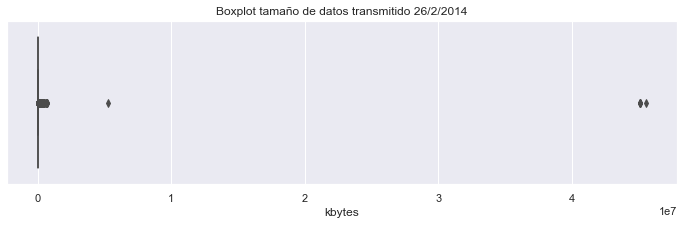

In [20]:
# Fig
fix,ax=plt.subplots(figsize=(12,3))

# Plot
box=sns.boxplot(data=miercoles,x='SIZE')

# Título
box.set(title='Boxplot tamaño de datos transmitido 26/2/2014',
        xlabel='kbytes');

El día 26/2 hubo un grupo de conexiones anómalo. Veámoslo en detalle.

In [21]:
miercoles.SIZE.describe()

count    3.647300e+04
mean     1.629166e+04
std      5.801659e+05
min      0.000000e+00
25%      4.190000e+02
50%      3.863000e+03
75%      8.158000e+03
max      4.556469e+07
Name: SIZE, dtype: float64

In [22]:
UWhisker=(miercoles.SIZE.quantile(0.75)-miercoles.SIZE.quantile(0.25))*1.5+miercoles.SIZE.quantile(0.75)
UWhisker

19766.5

In [23]:
anomalous=miercoles[miercoles.SIZE>1e7]
anomalous

,DAYoWEEK,Hour,USER,HOST,IP,REQ_METHOD,REQ_SOURCE,REQ_PROTOCOL,REQ_STATUS,SIZE,REFERER,USER-AGENT,city,region,country,OS_info,DEVICE_info,DIA,Traffic
161021,Wednesday,12,-,test.akumenius.com,80.28.221.123,GET,/newdesign/log/php/29,HTTP/1.1,200,45069075,http://test.akumenius.com/newdesign/log,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,Torrejón de Ardoz,Madrid,España,Fedora,Other,Feb/26/2014,Human
161419,Wednesday,13,-,test.akumenius.com,80.28.221.123,GET,/newdesign/log/php/108,HTTP/1.1,200,45071171,http://test.akumenius.com/newdesign/log,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,Torrejón de Ardoz,Madrid,España,Fedora,Other,Feb/26/2014,Human
161982,Wednesday,13,-,test.akumenius.com,80.28.221.123,GET,/newdesign/log/php/108,HTTP/1.1,200,45071171,http://test.akumenius.com/newdesign/log,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,Torrejón de Ardoz,Madrid,España,Fedora,Other,Feb/26/2014,Human
162365,Wednesday,13,-,test.akumenius.com,80.28.221.123,GET,/newdesign/log/php/169,HTTP/1.1,200,45073995,http://test.akumenius.com/newdesign/log,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,Torrejón de Ardoz,Madrid,España,Fedora,Other,Feb/26/2014,Human
162543,Wednesday,13,-,test.akumenius.com,80.28.221.123,GET,/newdesign/log/php/169,HTTP/1.1,200,45073995,http://test.akumenius.com/newdesign/log,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,Torrejón de Ardoz,Madrid,España,Fedora,Other,Feb/26/2014,Human
163263,Wednesday,13,-,test.akumenius.com,80.28.221.123,GET,/newdesign/log/php/218,HTTP/1.1,200,45564687,http://test.akumenius.com/newdesign/log,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,Torrejón de Ardoz,Madrid,España,Fedora,Other,Feb/26/2014,Human


In [24]:
anomalous.shape

(6, 19)

In [25]:
anomalous.IP.value_counts()

80.28.221.123    6
Name: IP, dtype: int64

Podemos decir que este tráfico anómalo se debe a alguna operación de actualización hecha desde la ip 80.28.221.123.

In [26]:
df.query('city=="Torrejón de Ardoz"')['IP'].unique()

array(['80.28.221.123'], dtype=object)

#### 4.1.1. Analizando los estados de respuesta de mis visitas.

Los diferentes estados de respuesta que se han dado en este periodo de tiempo en mi web son:

In [27]:
df.REQ_STATUS.unique()

array([200, 404, 304, 502, 301, 403, 408, 400, 206, 401, 302, 500],
      dtype=int64)

Para facilitar el análisis voy a categorizar la variable Status en familias de status, correspondiendo a:

- 200+: Conexión OK
- 300+: Redirección
- 400+: Error de cliente
- 500+: Error interno

Si el servicio web funcionase adecuadamente la mayoría de conexiones serían 200. Si observamos un número desproporcionado de otras familias deberíamos analizar que está sucediendo.

In [28]:
# Categorizar REQ_STATUS en familias
df['STATUS']=pd.cut(df.REQ_STATUS,bins=[200,300,400,500,600],
                 right=False,
                 labels=['200+','300+','400+','500+'],
                 ordered=True)

In [29]:
df.STATUS.value_counts(normalize=True)*100

200+    86.563334
300+    10.023179
400+     3.395539
500+     0.017948
Name: STATUS, dtype: float64

Parece que alrededor del 96% de nuestras visitas fueron exitosas y no se observa una proporción muy alta de errores (3,4%). Veamos como fueron los status día a día.

In [131]:
df.groupby('DIA').STATUS.value_counts(normalize=True)*100

DIA          STATUS
Feb/23/2014  200+      84.048747
             400+      14.912670
             300+       1.011447
             500+       0.027136
Feb/24/2014  200+      87.297851
             300+       7.977482
             400+       4.708291
             500+       0.016377
Feb/25/2014  200+      95.152156
             300+       4.437435
             400+       0.397864
             500+       0.012545
Feb/26/2014  200+      91.684260
             300+       7.923670
             400+       0.372879
             500+       0.019192
Feb/27/2014  200+      67.342760
             300+      32.447667
             400+       0.190302
             500+       0.019271
Feb/28/2014  200+      90.812468
             300+       8.896270
             400+       0.281042
             500+       0.010220
Mar/01/2014  200+      92.275621
             300+       7.425770
             400+       0.276072
             500+       0.022536
Mar/02/2014  200+      96.242775
             300+      

In [132]:
df.groupby(['DIA','STATUS'])['IP'].count()

DIA          STATUS
Feb/23/2014  200+      34070
             300+        410
             400+       6045
             500+         11
Feb/24/2014  200+      42645
             300+       3897
             400+       2300
             500+          8
Feb/25/2014  200+      53093
             300+       2476
             400+        222
             500+          7
Feb/26/2014  200+      33440
             300+       2890
             400+        136
             500+          7
Feb/27/2014  200+      27956
             300+      13470
             400+         79
             500+          8
Feb/28/2014  200+      17772
             300+       1741
             400+         55
             500+          2
Mar/01/2014  200+      16378
             300+       1318
             400+         49
             500+          4
Mar/02/2014  200+       1332
             300+         46
             400+          6
             500+          0
Name: IP, dtype: int64

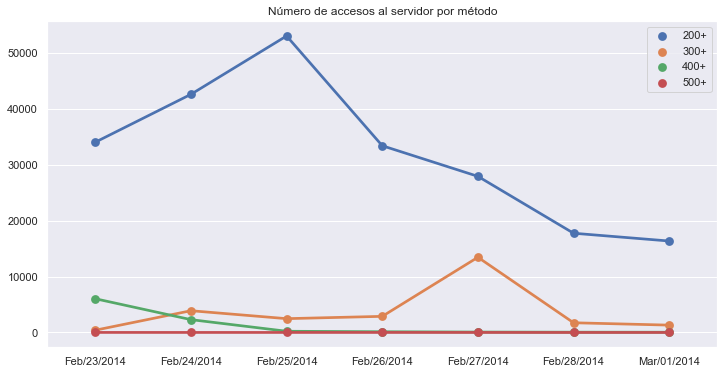

In [30]:

# Histograma de número de estados de respuesta por dia
# 1. Preparo datos

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot

var=sns.pointplot(data=df.query('DIA!="Mar/02/2014"').groupby(['DIA','STATUS'])[['IP']].count().reset_index(),
             hue='STATUS',
             x='DIA',
              y='IP',
            #legend=None,
            ax=ax)



# 4. Configuracion de imagen y anotaciones 
var.set(title='Número de accesos al servidor por método',
          ylabel=None,
          xlabel=None);

var.legend(loc='upper right');

La tasa de errores internos se mantiene muy baja durante toda la semana, sin embargo hay dos puntos que se salen de lo común, por un lado 23 y 24 de febrero hay un número más alto de lo normal de errores de cliente (400) y por otro lado, 26 y 27 de febrero se disparan las redirecciones (300). Veamos que ha podido pasar:

### Errores 300+

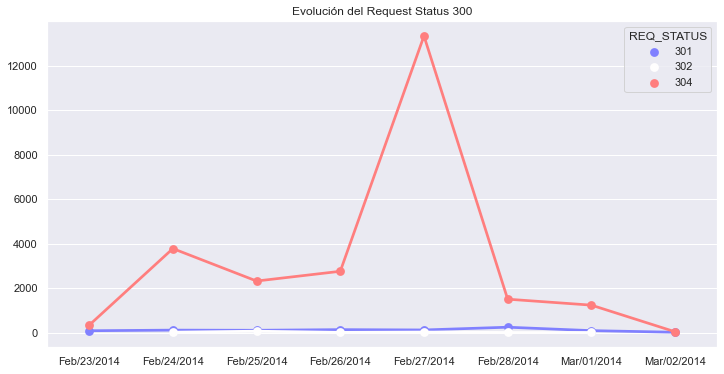

In [136]:

# Status Request 300+

# 1. Preparo datos

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot

g=sns.pointplot(data=df.query('STATUS=="300+"').groupby(['DIA','REQ_STATUS'])[['IP']].count().reset_index(),
             hue='REQ_STATUS',
             x='DIA',
             y='IP',
            palette='bwr',
            ax=ax)



# 4. Configuracion de imagen y anotaciones 
g.set(title='Evolución del Request Status 300',
          ylabel=None,
          xlabel=None);


Los principales errores de la familia 300 que podemos observar en nuestras conexiones son 301,302 y 304. El 304 es más habitual, aunque hay un día, el 21 de febrero que se disparan.

Para conocer algo más del error 304 puedes leer este [enlace] .A grandes rasgos, un código 304 es un código que comunica a tu navegador que: «El recurso solicitado no ha sido modificado desde la última vez que se accedió a él».

Esencialmente, tu navegador (o el de tu visitante) está siendo informado por el servidor de que los recursos almacenados (en caché) en el navegador no han sido modificados desde la última vez que visitó esa página.

A su vez, tu navegador recupera una versión guardada de la página web del caché. El propósito de esto es mejorar la velocidad y la entrega de la página, evitando que tu navegador tenga que descargar repetidamente la misma información.

[enlace]: https://kinsta.com/es/base-de-conocimiento/http-304/

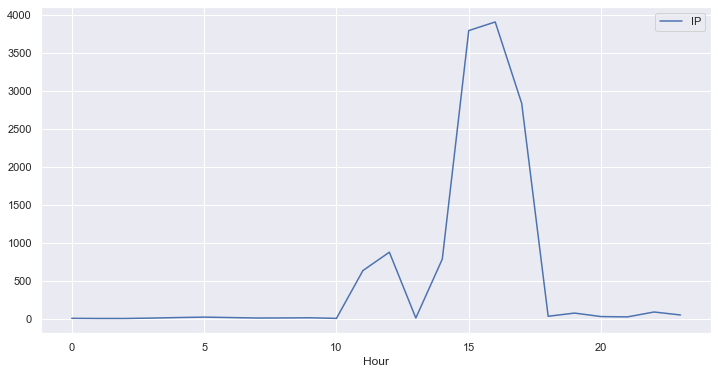

In [137]:
# Horas a las que se produce el response status 304.
df.query('REQ_STATUS=="304" and DIA=="Feb/27/2014"').groupby('Hour')[['IP']].count().plot(figsize=(12,6));

In [138]:
# Top 10 IPs que producen response status 304
df.query('REQ_STATUS=="304" and DIA=="Feb/27/2014"').IP.value_counts().head(10)

80.28.221.123     11295
195.57.124.71       730
62.117.197.230      634
217.12.16.130       132
217.125.71.222       79
95.18.84.69          69
95.63.234.126        58
5.255.253.81         51
217.12.28.130        31
87.217.56.160        28
Name: IP, dtype: int64

In [139]:
# Directorios que visita IP más activa.
df.query('REQ_STATUS=="304" and DIA=="Feb/27/2014" and IP=="80.28.221.123"').REQ_SOURCE.str.split('/',expand=True)[1].unique()

array(['newdesign', 'modules', 'includes', 'awstats', '', 'libraries'],
      dtype=object)

In [140]:
# Directorios que generan estatus 304
df.query('REQ_STATUS=="304"').REQ_SOURCE.str.split('/',expand=True)[1].unique()

array(['libraries', 'modules', 'includes', '', 'sitemap6.xml',
       'robots.txt', 'sitemap.xml', 'newdesign', 'awstats', 'icon.png'],
      dtype=object)

De nuevo encontramos que la dirección IP __80.28.221.123__ generó un número inusual de visitas el día 27/2. Estas visitas no pueden ser atribuidas de usuarios.

Tal como habíamos visto en el punto 4.1. lunes y martes eran los días más concurridos de la semana, probablemente debido a que nuestros usuarios dediacaban el principio de la semana para reservar sus actividades, y después se observaba una tendencia a la baja hasta el domingo. 

Aunque había un día que rompía esa tendencia que era el jueves, ahora vemos la causa de ese patrón anómalo y es que si filtramos los datos por origen se puede apreciar que el servicio técnico tuvo un gran volumen de accesos el jueves 27/2. 

En el siguiente gráfico se puede ver esa evolución del número de visitas, representado el número de visitas del servicio técnico contra el número de visitas por usuario.

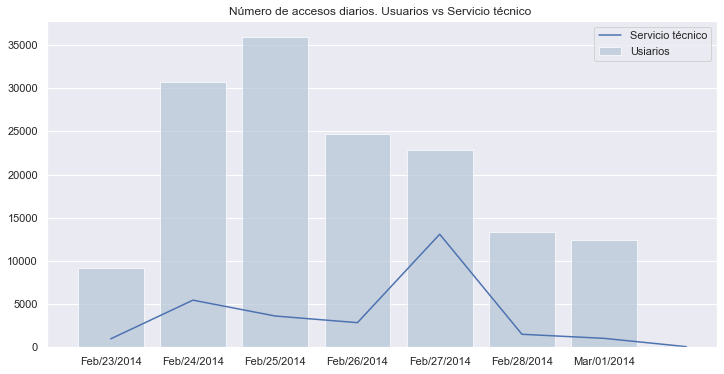

In [141]:

# Trafico semanal servicio técnico vs usuarios

# 1. Preparo datos
# Visitas reales
#realtrafic.query('HOST!="localhost " and HOST!="test.akumenius.com " ')

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot
trafico=sns.countplot(data=realtrafic.query('HOST!="localhost " and HOST!="test.akumenius.com " and DIA!="Mar/02/2014"'),
                        x='DIA',
                        alpha=0.7,
                        ax=ax,
                        label='Usiarios',
                        color='lightsteelblue'
                        )

sns.lineplot(data=realtrafic.query('HOST=="localhost " or HOST=="test.akumenius.com " and DIA!="Mar/02/2014"').groupby(['DIA'])[['IP']].count(),
             x='DIA',
             y='IP',
             ax=ax,
             legend='full',
             label='Servicio técnico')


# 4. Configuracion de imagen y anotaciones 
trafico.set(title='Número de accesos diarios. Usuarios vs Servicio técnico ',
          ylabel=None,
          xlabel=None);



### Errores 400+

Como vimos al inicio domingo lunes y martes hubo un número anómalo de errores 400. Vamos a intentar averiguar a que podrían ser debidos.

In [142]:
# Tipo de tráfico que provoca errores 400
df.query('STATUS=="400+" and DIA<"Feb/26/2014"').Traffic.value_counts()

Bot      8328
Human     239
Name: Traffic, dtype: int64

In [143]:
# Distribución de errores
df.query('STATUS=="400+"').groupby(['REQ_STATUS']).Traffic.value_counts()

REQ_STATUS  Traffic
400         Human        26
401         Human         5
403         Human       143
            Bot          51
404         Bot        8391
            Human       239
408         Human        37
Name: Traffic, dtype: int64

Parece que la inmensa mayoría de errores 400 son errores de tipo 404. En este caso hay un número muy desproporcionado de errores provocados por BOTS y aunque el número de usuarios que tuvieron ese error es también muy desproporcionado.

Un error 404 quiere decir que el cliente pudo conectarse con éxito con el host, pero no pudo encontrar el recurso que estaba pidiendo.

Por ejemplo, si alguien intenta acceder susitio.com/nombre-articulo, pero usted no tiene contenido con el slug nombre-articulo. El visitante verá el error 404 porque a pesar de que su servidor esté funcionando correctamente, el recurso buscado no existe.

Y no sólo son los artículos o páginas, cualquier recurso que haga falta puede generar un error 404 en el servidor, tal como una imagen faltante, JavaScript o CSS faltante, etc..

Así pues podemos pensar que estos errores deben a que hubo algún link que no funcionaba correctamente durante esos días.

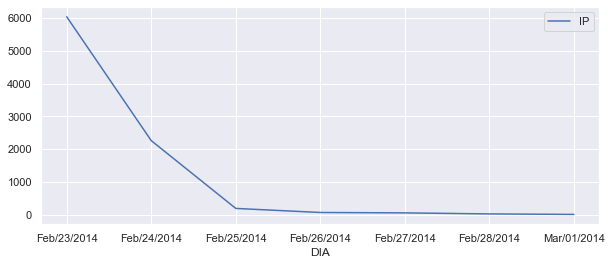

In [144]:
# Cuando se produce el response status 404.
df.query('REQ_STATUS=="404"').groupby('DIA')[['IP']].count().plot(figsize=(10,4));

Vemos que el número de veces que ocurre el error 404 disminuye entre el domingo y el martes. Hay que tener en cuenta que disminuye en la misma proporción que el tráfico de bots (3 a 1), con lo cual podemos  asumir que durante el domingo y el lunes hubo un problema con algun recurso que se solucionó a partir del martes.

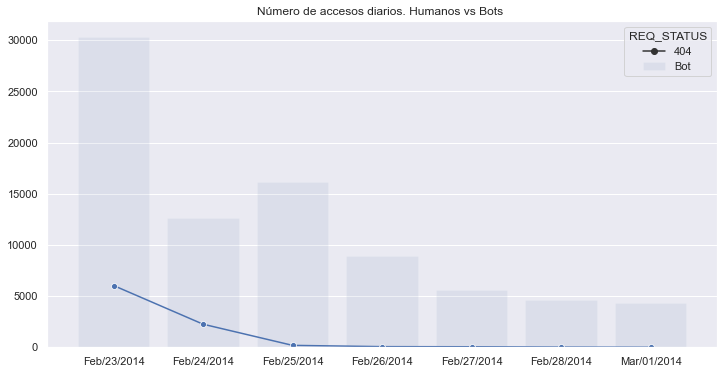

In [145]:

# Trafico semanal

# 1. Preparo datos

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot
trafico=sns.countplot(data=bottrafic.query('DIA!="Mar/02/2014"'),
                        x='DIA',
                        hue='Traffic',
                        alpha=0.1,
                        ax=ax)

trafico=sns.lineplot(data=df.query('REQ_STATUS=="404" and DIA!="Mar/02/2014"').groupby(['DIA','REQ_STATUS'])[['IP']].count().reset_index(),
            x='DIA',
            y='IP',
            legend='full',
            style='REQ_STATUS',
            markers=True,         
            ax=ax)



# 4. Configuracion de imagen y anotaciones 
ax.set(title='Número de accesos diarios. Humanos vs Bots ',
          ylabel=None,
          xlabel=None);


In [146]:
# Número de direcciones que generan 404.
df.query('REQ_STATUS=="404" and DIA<"Feb/26/2014"').REQ_SOURCE.nunique()

8128

In [147]:
# Principaples direcciones
df.query('REQ_STATUS=="404" and DIA<"Feb/26/2014"').REQ_SOURCE.value_counts().head(3)

/favicon.ico                                                                                       60
/hoteles-baratos/ofertas-hotel-Castillo-del-Buen-Amor-en-Topas-25543b-destinos.html                 6
/hoteles-baratos/ofertas-hotel-Hostal-La-Escapada-en-Uleila%20del%20Campo-178890b-destinos.html     4
Name: REQ_SOURCE, dtype: int64

In [148]:
# Principales directorios
df.query('REQ_STATUS=="404" and DIA<"Feb/26/2014"').REQ_SOURCE.str.split('/',expand=True)[1].value_counts()

hoteles-baratos     4568
destinos-baratos    3855
favicon.ico           60
awstats                1
newdesign              1
Name: 1, dtype: int64

In [149]:
# Accesos que empiecen por /hoteles-baratos con error 404.
(
df[df.REQ_SOURCE.str.startswith("/hoteles-baratos/ofertas-hotel")].
    query('REQ_STATUS=="404" and DIA<"Feb/26/2014"').
    REQ_SOURCE.str.split('/',expand=True)[2].count()
  )

4558

In [150]:
# Accesos que empiecen por /destinos-baratos/hoteles-baratos con error 404.
(
df[df.REQ_SOURCE.str.startswith("/destinos-baratos/hoteles-baratos")].
    query('REQ_STATUS=="404" and DIA<"Feb/26/2014"')
    .REQ_SOURCE.count()
  )

3855

In [151]:
# Numero de accesos que empiezan por /destinos-baratos/hoteles-baratos y no dan error 404
(
df[df.REQ_SOURCE.str.startswith("/hoteles-baratos/")]
    .query('REQ_STATUS!="404" and DIA<"Feb/26/2014"')
    .REQ_SOURCE.str.split('/',expand=True)[2].count()
)

1165

La mayoría de errores 404 son provocados por spiders que recorren automáticamente la web. 4588 direcciones que no se encontraron empezaban por _/hoteles-baratos/ofertas-hotel_ y 3855 por _/destinos-baratos/hoteles-baratos_, probablemente estos errores se deban a recursos que ya no existen, por que haya caducado la oferta o el anunciante la haya retirado. A partir del martes estos errores desaparecen, lo que quiere decir que han sido reparados por el servicio técnico.  

## 4.2. Visitas por ubicación geográfica.

Veamos ahora de donde provienen las visitas a nuestra web.

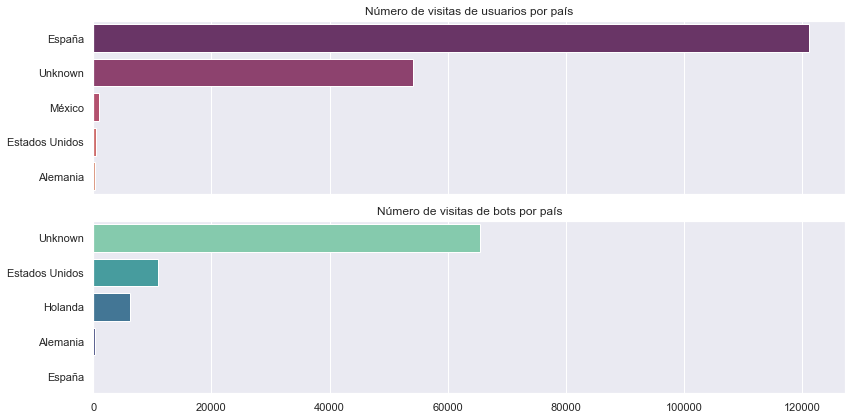

In [152]:
# Histograma de número de visitas por pais
# 1. Preparo datos
# 2. Creo fig y axes.
fig, (ax1,ax2)=plt.subplots(figsize=(12, 6),ncols=1,nrows=2,sharex=True,tight_layout=True)

# 3. Creo Plot
real=sns.barplot(data=realtrafic.groupby('country')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(5),
                    y='country',  
                    x='IP',
                    palette='flare_r',
                    ax=ax1)

bot=sns.barplot(data=bottrafic.groupby('country')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(5),
                    y='country',  
                    x='IP',
                    palette='mako_r',
                    ax=ax2)


# 4. Configuracion de imagen y anotaciones 
real.set(title='Número de visitas de usuarios por país',
          ylabel=None,
          xlabel=None);

bot.set(title='Número de visitas de bots por país',
          ylabel=None,
          xlabel=None);



Da la sensación de que nuestro público está principalmente en España. Vamos aprofundizar un poco más y veamos que regiones acumulan mayor número de visitas.  

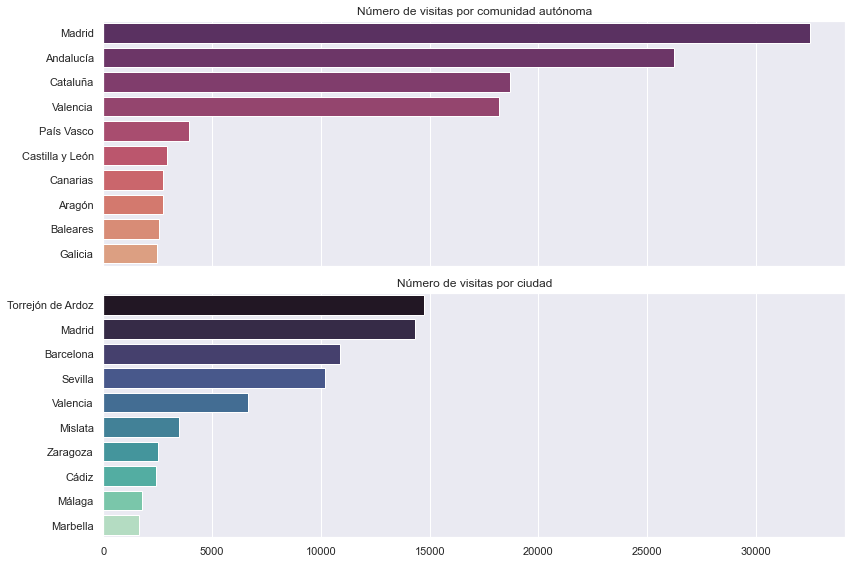

In [153]:
# Histograma de número de visitas por CCAA
# 1. Preparo datos
CCAA= realtrafic.query('country=="España"').groupby('region')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10)
Ciudad= realtrafic.query('country=="España"').groupby('city')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10)

# 2. Creo fig y axes.
fig,(ax1,ax2)=plt.subplots(figsize=(12, 8),ncols=1,nrows=2,sharex=True,tight_layout=True)


# 3. Creo Plot
comunidad=sns.barplot(data=CCAA,
                    y='region',  
                    x='IP',
                    palette='flare_r',
                   ax=ax1)

ciudad=sns.barplot(data=Ciudad,
                    y='city',  
                    x='IP',
                    palette='mako',
                   ax=ax2)


# 4. Configuracion de imagen y anotaciones 
comunidad.set(title='Número de visitas por comunidad autónoma',
          ylabel=None,
          xlabel=None);


ciudad.set(title='Número de visitas por ciudad',
          ylabel=None,
          xlabel=None);


Analizando por provincias, Madrid, Andalucía y Cataluña son las regiones desde donde más visitas recibimos.

En este punto creo que sería interesante distinguir los accesos de IP que estén asociados a personas que trabajen en el mantenimiento de la página.

In [154]:
df.HOST.unique()

array(['localhost ', 'www.akumenius.com ', 'akumenius.com ',
       'akumenius.es ', 'test.akumenius.com '], dtype=object)

Asumo que las ips que acceden a través de localhost o test.akumenius.com serían las que corresponden a personas que trabajan en le mantenimiento de la web. En total suponen unas 37.514 visitas.

In [155]:
ip_test=df[(df.HOST=='test.akumenius.com ' )].IP.unique()

In [156]:
ip_localhost=df[(df.HOST=='localhost ') ].IP.unique()

In [157]:
df[(df.IP.isin(ip_test))].IP.value_counts().sum()

22322

In [158]:
df[df.IP.isin(ip_localhost)].IP.value_counts().sum()

15192

Como quedarían las visitas pos CCAA y Ciudades si no tenemos en cuenta las visitas de trabajadores de la web?

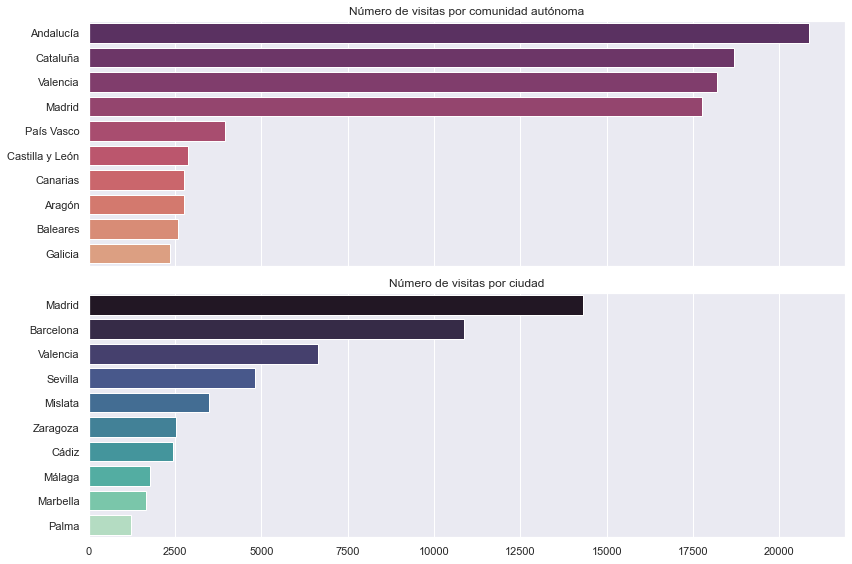

In [159]:
# Histograma de número de visitas por CCAA sin accesos localhost ni test.akumenius 
# 1. Preparo datos
filter1=realtrafic[(realtrafic['country']=="España")&(~(realtrafic.IP.isin(ip_test))&~(realtrafic.IP.isin(ip_localhost)))]

CCAA= filter1.groupby('region')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10)
Ciudad= filter1.groupby('city')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10)

# 2. Creo fig y axes.
fig,(ax1,ax2)=plt.subplots(figsize=(12, 8),ncols=1,nrows=2,sharex=True,tight_layout=True)


# 3. Creo Plot
comunidad=sns.barplot(data=CCAA,
                    y='region',  
                    x='IP',
                    palette='flare_r',
                    ax=ax1)

ciudad=sns.barplot(data=Ciudad,
                    y='city',  
                    x='IP',
                    palette='mako',
                    ax=ax2)


# 4. Configuracion de imagen y anotaciones 
comunidad.set(title='Número de visitas por comunidad autónoma',ylabel=None,xlabel=None);


ciudad.set(title='Número de visitas por ciudad',ylabel=None,xlabel=None);


In [160]:
filter1.REQ_METHOD.value_counts()

GET     90598
POST    10337
HEAD        2
Name: REQ_METHOD, dtype: int64

Por comunidades autónomas podemos decir que la mayoría de visitas viene de Andalucía, Cataluña y Valencia, aunque la ciudad que más número de visitas nos hace es Madrid.

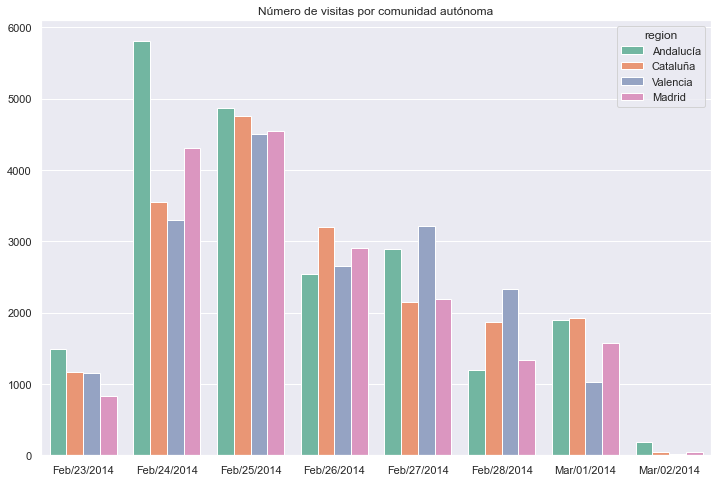

In [161]:
# Histograma de número de visitas por CCAA sin accesos localhost ni test.akumenius 
# 1. Preparo datos
comunidades=['Andalucía','Valencia','Cataluña','Madrid']
filter2=realtrafic[(realtrafic['country']=="España")&
                   (~(realtrafic.IP.isin(ip_test))&~(realtrafic.IP.isin(ip_localhost))&
                   (realtrafic.region.isin(comunidades)))]

CCAA= filter2.groupby(['DIA','region'])[['IP']].count().reset_index().sort_values(by=['DIA','IP'],ascending=[True,False])
#Ciudad= filter1.groupby('city')[['IP']].count().sort_values(by='IP',ascending=False).reset_index().head(10)

# 2. Creo fig y axes.
fig,(ax1)=plt.subplots(figsize=(12, 8))


# 3. Creo Plot
comunidad=sns.barplot(data=CCAA,
                    hue='region',  
                    y='IP',
                    x='DIA',
                    palette='Set2',
                    ax=ax1)


# 4. Configuracion de imagen y anotaciones 
comunidad.set(title='Número de visitas por comunidad autónoma',ylabel=None,xlabel=None);





## 4.3. Analizando REQ_SOURCES

Si observamos el número de accesos que ha tenido nuestra página por tipo de método de acceso tenemos:

In [162]:
realtrafic.REQ_METHOD.value_counts()

GET                  148251
POST                  16660
OPTIONS               13892
HEAD                    132
-                        37
\x80w\x01\x03\x01         5
Name: REQ_METHOD, dtype: int64

Y esto distribuido a lo largo de la semana:

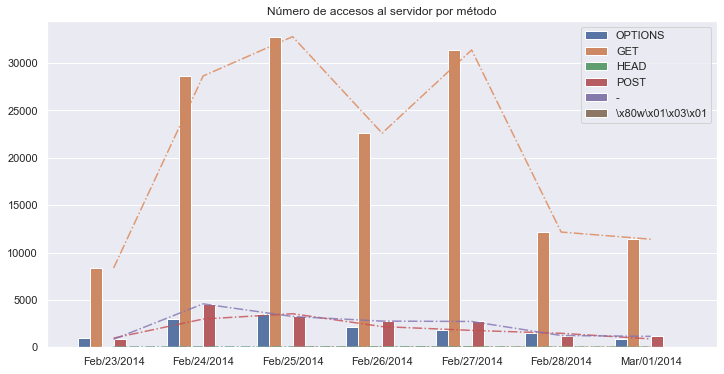

In [163]:

# Histograma de número de visitas por dia
# 1. Preparo datos

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot
trafico=sns.countplot(data=realtrafic.query('DIA!="Mar/02/2014"'),
                      x='DIA',
                      hue='REQ_METHOD',
                      ax=ax)

sns.lineplot(data=realtrafic.query('DIA!="Mar/02/2014"').groupby(['DIA','REQ_METHOD'])[['IP']].count(),
            y='IP',
            hue='REQ_METHOD',
            x='DIA',
             alpha=0.8,
             linestyle='-.',
             legend=None,
            ax=ax)



# 4. Configuracion de imagen y anotaciones 
trafico.set(title='Número de accesos al servidor por método',
          ylabel=None,
          xlabel=None);

trafico.legend(loc='upper right');

Los accesos con el método OPTIONS tienen valores mayores a principio de semana y luego van decreciendo hasta el domingo. Probablemente a principio de semana se requiere un mayor trabajo en el mantenimiento de la web que hace que lunes y martes sean días con más accesos, mientras que miércoles jueves y viernes disminuye el tráfico. 

Con las accesos con el método POST pasa algo parecido, lunes y martes son días con muchas entradas, tal vez se deba a tareas de actualización de anuncios o a subidas de comentarios.

En el tráfico generado el método GET vemos que lunes y martes son días con mucho tráfico, tal vez debido a que muchos usuarios empiezan a buscar planes para el fin de semana y aunque las visitas caen el miércoles, el jueves vuelven a subir, aunque como ya vimos el jueves hubo un elevado número de visitas realizadas por el servicio técnico.

Por último en general vemos que el tráfico cae de viernes a domingo.

Veamos a donde buscan acceder los diferente métodos.

In [164]:
# Lista de métodos
df.REQ_METHOD.unique()

array(['OPTIONS', 'GET', 'HEAD', 'POST', '-', '\\x80w\\x01\\x03\\x01'],
      dtype=object)

### 4.3.1. OPTIONS

In [165]:
df[df.REQ_METHOD=='OPTIONS'].REQ_SOURCE.unique()

array(['*'], dtype=object)

In [166]:
df[df.REQ_METHOD=='OPTIONS'].STATUS.unique()

['200+']
Categories (1, object): ['200+']

In [179]:
# Performance estado accesos OPTIONS
df[df.REQ_METHOD=='OPTIONS'].STATUS.value_counts(normalize=True)

200+    1.0
500+    0.0
400+    0.0
300+    0.0
Name: STATUS, dtype: float64

### 4.3.2. POST

In [167]:
print('Número de visitas con POST totales: ',df[df.REQ_METHOD=='POST'].REQ_SOURCE.count(),'\n')
print('Número de diferentes fuentes: ',df[df.REQ_METHOD=='POST'].REQ_SOURCE.nunique())

Número de visitas con POST totales:  16669 

Número de diferentes fuentes:  343


In [168]:
# Top 10 carpetas con más accesos por POST. 
df[df.REQ_METHOD=='POST'].REQ_SOURCE.str.split('/',expand=True)[1].value_counts().head(10)

destinos-get                    8115
hotel-list-data                 3439
raton-search                    1694
newdesign                       1120
destinos-insert                  862
hotel-translate-get              184
raton-search2                    171
hotel-translate-name-new-get     149
booking                          147
hoteles-baratos                  141
Name: 1, dtype: int64

In [169]:
# Performance estado accesos POST
df[df.REQ_METHOD=='POST'].STATUS.value_counts(normalize=True)

200+    0.993401
300+    0.004799
400+    0.001620
500+    0.000180
Name: STATUS, dtype: float64

### 4.3.3. HEAD

In [170]:
print('Número de visitas con HEAD totales: ',df[df.REQ_METHOD=='HEAD'].REQ_SOURCE.count(),'\n')
print('Número de diferentes fuentes: ',df[df.REQ_METHOD=='HEAD'].REQ_SOURCE.nunique())

Número de visitas con HEAD totales:  1788 

Número de diferentes fuentes:  25


In [171]:
df[df.REQ_METHOD=='HEAD'].REQ_SOURCE.str.split('/',expand=True)[1].value_counts()

              1745
libraries       14
modules         12
chollos          5
includes         4
icon.png         3
escapadas        3
robots.txt       2
Name: 1, dtype: int64

In [177]:
# Performance estado accesos HEAD
df[df.REQ_METHOD=='HEAD'].STATUS.value_counts(normalize=True)

200+    0.946868
300+    0.039709
400+    0.013423
500+    0.000000
Name: STATUS, dtype: float64

### 4.3.4. GET

In [172]:
print('Número de visitas con GET totales: ',df[df.REQ_METHOD=='GET'].REQ_SOURCE.count(),'\n')
print('Número de diferentes fuentes: ',df[df.REQ_METHOD=='GET'].REQ_SOURCE.nunique())

Número de visitas con GET totales:  229482 

Número de diferentes fuentes:  65778


In [178]:
# Performance estado accesos GET
df[df.REQ_METHOD=='GET'].STATUS.value_counts(normalize=True)

200+    0.847744
300+    0.113721
400+    0.038343
500+    0.000192
Name: STATUS, dtype: float64

In [173]:
# Directorios más visitados
realtrafic.REQ_SOURCE.str.split('/',expand=True)[[1]].value_counts().head(15)

1                      
modules                    60694
libraries                  39331
newdesign                  14314
includes                   13373
destinos-get                8115
                            7115
hotel-list-data             3439
escapadas                   2791
hotel-list                  1972
agencias_europlayas         1910
raton-search                1694
hoteles-baratos             1543
icon.png                    1116
hotels-consulted-update     1007
destinos-baratos             968
dtype: int64

Folders como modules, libraries, newdesign o included contienen información sobre elementos de la arquitectura web. Veamos que viajes son los más buscados por nuestros usuarios: 

In [174]:
realtrafic[realtrafic.REQ_SOURCE.str.startswith('/escapadas/')
          ].REQ_SOURCE.str.split('/',expand=True)[2].value_counts().head(10)

cataluna-154_files                                                            915
escapada-golf-islantilla-golf-resort-0437afab49458d7bd5a48954a459ad6d.html    143
general-550                                                                   134
andalucia-713                                                                 102
escapada-golf-hotel-elba-estepona-0cc275f95c9f11febf96eedab9465da3.html       100
hotel-spa-493                                                                  74
aragon-718                                                                     67
golf-500.html                                                                  56
romanticas-492                                                                 52
andalucia-713.html                                                             38
Name: 2, dtype: int64

In [175]:
realtrafic[realtrafic.REQ_SOURCE.str.startswith('/hoteles-baratos/')
          ].REQ_SOURCE.str.split('/',expand=True)[2].value_counts().head(10)

hoteles-todo-incluido.html                                                   382
ofertas-vacaciones-verano.html                                                92
ofertas-hoteles-todo-incluido-en-algarve_PORTUGAL.html                        84
ofertas-hoteles-semana-santa.html                                             41
ofertas-hoteles-todo-incluido-en-benidorm_ESPA%C3%91A.html                    40
ofertas-hoteles-todo-incluido-en-roquetas-de-mar_ESPA%C3%91A.html             36
ofertas-hoteles-todo-incluido-en-chiclana-de-la-frontera_ESPA%C3%91A.html     36
ofertas-hoteles-todo-incluido-en-albir_ESPA%C3%91A.html                       26
ofertas-hoteles-puente-andalucia.html                                         22
ofertas-hoteles-todo-incluido-en-salou_ESPA%C3%91A.html                       19
Name: 2, dtype: int64

In [176]:
realtrafic[realtrafic.REQ_SOURCE.str.startswith('/destinos-baratos/')
          ].REQ_SOURCE.str.split('/',expand=True)[2].value_counts().head(10)

hoteles-baratos                          114
destinos-caracteristicas                  64
hoteles-en-Benidorm_ESPA%C3%91A           22
hoteles-en-Granada_ESPA%C3%91A            21
hoteles-en-Barcelona_ESPA%C3%91A          12
hoteles-en-C%C3%A1diz_ESPA%C3%91A         11
hoteles-en-Alicante_ESPA%C3%91A           10
hoteles-en-Pe%C3%B1iscola_ESPA%C3%91A     10
hoteles-en-Madrid_ESPA%C3%91A             10
hoteles-en-Mykonos_GRECIA                  9
Name: 2, dtype: int64

En general nuestros usuarios buscan hoteles baratos o con todo incluido, Cataluña y Andalucía como destinos más habituales y ofertas para verano y semana santa. 

## 5. Resumen.

En este notebook hemos extraido la información de un registro log. Para ello en primer lugar tuvimos que ir identificando los diferentes campos de cara registro. La particularidad en este caso es que los campos no están separados por caracteres, así que tuvimos que hacer uso de expresiones regulares y algunas funciones de tratamiento de strings de la librería de Pandas para ir obteniendo los diferentes campos.

Una vez preparada la tabla para analizar conectamos el notebook con una API que nos permitió geolocalizar las IPs y con ayuda de una librería especializada en parsear user agents pudimos inferir el tipo de dispositivo que conectaba con nuestra web, el sistema operativo o si era un Bot o no.

Con toda la información extraida pudimos ver que días había más tráfico o cuales eran las horas de conexión más usuales de nuestra audiencia. Fuimos capaces de detectar diferentes incidencias e incluso que día se actualizó el sistema. La información de geolocalización de las IPs, nos ayudó a conocer que nuestro público era mayoritariamente nacional y que las ciudades que más nos visitaban eran Madrid, Barcelona y Valencia. 